<a href="https://colab.research.google.com/github/amythemirror/Springboard-Capstone-Three/blob/main/Sentiment_Analysis_LSTM_Input_Length_74.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [2]:
import numpy as np
import pandas as pd
from ast import literal_eval

df = pd.read_csv('/content/drive/MyDrive/Springboard/Capstone Three/data_wrangling.csv',\
                usecols=['reviewClean_sw', 'reviewLength', 'sentiment'],\
                converters={'reviewClean_sw': literal_eval})
df.head()

,reviewClean_sw,reviewLength,sentiment
0,"[exactly, what, i, need, .]",5,Positive
1,"[i, agree, with, the, other, review, ,, the, o...",52,Negative
2,"[love, these, ..., i, be, go, to, order, anoth...",54,Positive
3,"[too, tiny, an, opening]",4,Negative
4,[okay],1,Neutral


In [3]:
df.shape

(852589, 3)

In [4]:
# compute 90% percentile for review length
df.reviewLength.quantile(q=0.9)

74.0

In [5]:
from sklearn.model_selection import train_test_split

# take 25% of the data to train model
_, df_sample = train_test_split(df, test_size=0.25, random_state=42)
df_sample.head()

,reviewClean_sw,reviewLength,sentiment
717508,"[way, ,, way, ,, way, too, small, ., it, be, l...",24,Negative
766819,"[i, be, a, 34b, the, strap, be, adjustable, an...",29,Positive
320423,"[the, dress, be, large, in, the, waist, and, t...",36,Positive
848277,"[jean, fit, well, but, notice, about, flammabi...",18,Neutral
790409,"[stylish, and, well, make, ., true, to, size, ...",21,Positive


In [6]:
X = df_sample['reviewClean_sw'].values
y = df_sample['sentiment'].values

X, y

(array([list(['way', ',', 'way', ',', 'way', 'too', 'small', '.', 'it', 'be', 'lable', 'as', 'an', 'xxl', 'and', 'fit', 'like', 'a', 'large', 'at', 'good', '.', 'beware', '.']),
        list(['i', 'be', 'a', '34b', 'the', 'strap', 'be', 'adjustable', 'and', 'you', 'can', 'not', 'see', 'the', 'nipple', 'through', 'the', 'shirt', 'which', 'be', 'great', '.', 'i', 'purchase', 'a', 'medium', '.', 'great', 'buy']),
        list(['the', 'dress', 'be', 'large', 'in', 'the', 'waist', 'and', 'the', 'slit', 'be', 'very', 'high', '(', 'do', 'not', 'sit', 'down', ')', '.', 'once', 'i', 'have', 'it', 'tailor', 'and', 'the', 'slit', 'closed', ',', 'it', 'be', 'a', 'beautiful', 'dress', '!']),
        ...,
        list(['not', 'bad', 'for', 'price', '.', 'start', 'turn', 'color', 'on', 'metal']),
        list(['disappoint', 'in', 'this', 'hat', '!', 'we', 'buy', 'it', '3', 'month', 'ago', 'and', 'my', 'son', 'wear', 'it', '5', 'time', '.', 'it', 'be', 'great', 'when', 'he', 'wear', 'it', ',', 'but', 

In [7]:
def convert_list_to_string(org_list, seperator=' '):
    """ Convert list to string, by joining all item in list with given separator.
        Returns the concatenated string """
    return seperator.join(org_list)

X = [convert_list_to_string(tokens) for tokens in X]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

# Feature Engineering

In [9]:
import gensim.downloader as api

# load gensim pretrained w2v model
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [10]:
from tqdm import tqdm

# helper function to embed strings into w2v vectors
def w2v_embedding(reviews):
    review_vecs = []

    for tokens in tqdm(reviews):
        token_vecs = []
        for token in tokens:
            try:
                token_vecs.append(wv[token])
            except KeyError:
                pass
        review_vecs.append(token_vecs)
    
    return review_vecs

In [11]:
X_train = w2v_embedding(X_train)
# X_test = w2v_embedding(X_test)

100%|██████████| 170518/170518 [00:30<00:00, 5529.43it/s]


In [12]:
from keras.preprocessing import sequence
from keras.utils import np_utils

maxlen = 74

X_train = sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post', dtype='float32')
# X_test = sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post', dtype='float32')

In [13]:
from sklearn.preprocessing import LabelEncoder

# encode text sentiment labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
# y_test = encoder.transform(y_test)

encoder.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [14]:
# one-hot encode y for lstm
y_train = np_utils.to_categorical(y_train)

In [15]:
!pip install attention

In [16]:
maxlen = 74
batch_size = 32
embedding_dims = 300
epochs = 100

## 50 neurons

In [28]:
from attention import Attention
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional

num_neurons = 50

model = Sequential()
model.add(Bidirectional(LSTM(num_neurons, return_sequences=True,
               input_shape=(maxlen, embedding_dims))))
model.add(Attention(name='attention_weight'))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))

model.compile('rmsprop', 'categorical_crossentropy',  metrics=['accuracy'])

In [29]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the model with the best accuracy on the test dataset
mc = ModelCheckpoint('/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_50neuron.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [30]:
hist = model.fit(X_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 callbacks=[mc, es],
                 validation_split=0.1)

Epoch 1/100
4796/4796 [==============================] - 72s 14ms/step - loss: 0.6951 - accuracy: 0.7308 - val_loss: 0.5445 - val_accuracy: 0.7821

Epoch 00001: val_accuracy improved from -inf to 0.78208, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_50neuron.h5
Epoch 2/100
4796/4796 [==============================] - 68s 14ms/step - loss: 0.5319 - accuracy: 0.7917 - val_loss: 0.5291 - val_accuracy: 0.7892

Epoch 00002: val_accuracy improved from 0.78208 to 0.78917, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_50neuron.h5
Epoch 3/100
4796/4796 [==============================] - 68s 14ms/step - loss: 0.5004 - accuracy: 0.8040 - val_loss: 0.5168 - val_accuracy: 0.7922

Epoch 00003: val_accuracy improved from 0.78917 to 0.79217, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_50neuron.h5
Epoch 4/100
4796/4796 [=============================

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 74, 100)           140400    
_________________________________________________________________
attention_score_vec (Dense)  (None, 74, 100)           10000     
_________________________________________________________________
last_hidden_state (Lambda)   (None, 100)               0         
_________________________________________________________________
attention_score (Dot)        (None, 74)                0         
_________________________________________________________________
attention_weight (Activation (None, 74)                0         
_________________________________________________________________
context_vector (Dot)         (None, 100)               0         
_________________________________________________________________
attention_output (Concatenat (None, 200)              

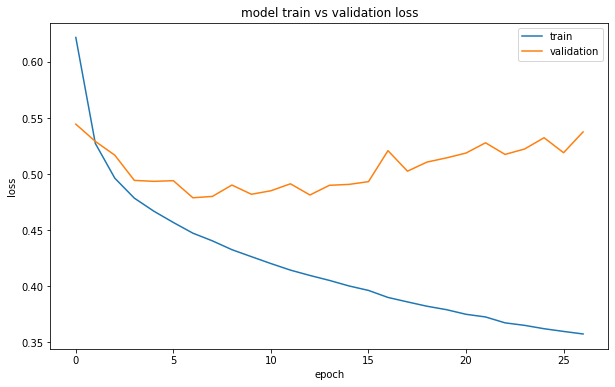

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
model_structure = model.to_json()

with open("/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_50neuron.json", "w") as json_file:
    json_file.write(model_structure)
 
model.save_weights("/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_50neuron_final.h5")

## 100 neurons

In [16]:
from attention import Attention
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional

num_neurons = 100

model = Sequential()
model.add(Bidirectional(LSTM(num_neurons, return_sequences=True,
               input_shape=(maxlen, embedding_dims))))
model.add(Attention(name='attention_weight'))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))

model.compile('rmsprop', 'categorical_crossentropy',  metrics=['accuracy'])

In [19]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the model with the best accuracy on the test dataset
mc = ModelCheckpoint('/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_100neuron.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [20]:
hist = model.fit(X_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 callbacks=[mc, es],
                 validation_split=0.1)

Epoch 1/100
4796/4796 [==============================] - 68s 14ms/step - loss: 0.6184 - accuracy: 0.7562 - val_loss: 0.5398 - val_accuracy: 0.7883

Epoch 00001: val_accuracy improved from -inf to 0.78829, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_100neuron.h5
Epoch 2/100
4796/4796 [==============================] - 68s 14ms/step - loss: 0.5239 - accuracy: 0.7943 - val_loss: 0.5098 - val_accuracy: 0.8011

Epoch 00002: val_accuracy improved from 0.78829 to 0.80114, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_100neuron.h5
Epoch 3/100
4796/4796 [==============================] - 67s 14ms/step - loss: 0.4924 - accuracy: 0.8062 - val_loss: 0.4968 - val_accuracy: 0.8032

Epoch 00003: val_accuracy improved from 0.80114 to 0.80319, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_100neuron.h5
Epoch 4/100
4796/4796 [==========================

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 74, 200)           320800    
_________________________________________________________________
attention_score_vec (Dense)  (None, 74, 200)           40000     
_________________________________________________________________
last_hidden_state (Lambda)   (None, 200)               0         
_________________________________________________________________
attention_score (Dot)        (None, 74)                0         
_________________________________________________________________
attention_weight (Activation (None, 74)                0         
_________________________________________________________________
context_vector (Dot)         (None, 200)               0         
_________________________________________________________________
attention_output (Concatenat (None, 400)               0

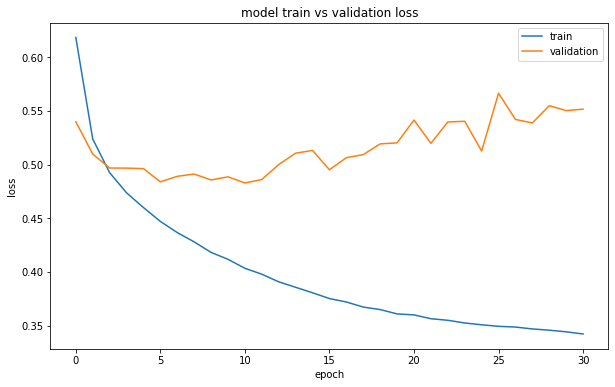

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [23]:
model_structure = model.to_json()

with open("/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_100neuron.json", "w") as json_file:
    json_file.write(model_structure)
 
model.save_weights("/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_100neuron_final.h5")

## 200 neurons

In [34]:
from attention import Attention
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional

num_neurons = 200

model = Sequential()
model.add(Bidirectional(LSTM(num_neurons, return_sequences=True,
               input_shape=(maxlen, embedding_dims))))
model.add(Attention(name='attention_weight'))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))

model.compile('rmsprop', 'categorical_crossentropy',  metrics=['accuracy'])

# print(model.summary())

In [35]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# save the model with the best accuracy on the test dataset
mc = ModelCheckpoint('/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [38]:
hist = model.fit(X_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 callbacks=[mc, es],
                 validation_split=0.1)

Epoch 1/100
4796/4796 [==============================] - 82s 17ms/step - loss: 0.5959 - accuracy: 0.7653 - val_loss: 0.5469 - val_accuracy: 0.7833

Epoch 00001: val_accuracy improved from -inf to 0.78331, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput.h5
Epoch 2/100
4796/4796 [==============================] - 80s 17ms/step - loss: 0.5221 - accuracy: 0.7958 - val_loss: 0.5031 - val_accuracy: 0.8025

Epoch 00002: val_accuracy improved from 0.78331 to 0.80249, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput.h5
Epoch 3/100
4796/4796 [==============================] - 80s 17ms/step - loss: 0.4913 - accuracy: 0.8076 - val_loss: 0.4867 - val_accuracy: 0.8098

Epoch 00003: val_accuracy improved from 0.80249 to 0.80976, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput.h5
Epoch 4/100
4796/4796 [==============================] - 80s 17ms/step - loss: 

In [56]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 74, 400)           801600    
_________________________________________________________________
attention_score_vec (Dense)  (None, 74, 400)           160000    
_________________________________________________________________
last_hidden_state (Lambda)   (None, 400)               0         
_________________________________________________________________
attention_score (Dot)        (None, 74)                0         
_________________________________________________________________
attention_weight (Activation (None, 74)                0         
_________________________________________________________________
context_vector (Dot)         (None, 400)               0         
_________________________________________________________________
attention_output (Concatenat (None, 800)              

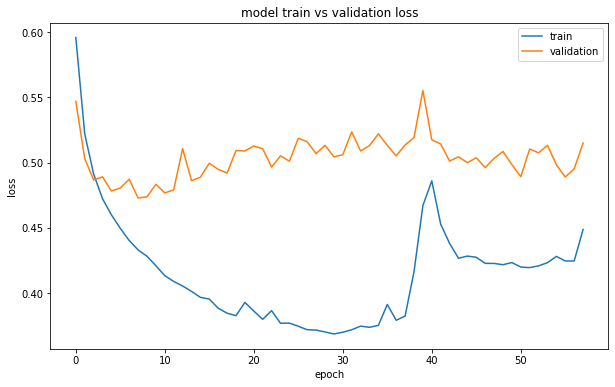

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## 500 neurons

In [33]:
from attention import Attention
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional

num_neurons = 500

model = Sequential()
model.add(Bidirectional(LSTM(num_neurons, return_sequences=True,
               input_shape=(maxlen, embedding_dims))))
model.add(Attention(name='attention_weight'))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))

model.compile('rmsprop', 'categorical_crossentropy',  metrics=['accuracy'])

In [34]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the model with the best accuracy on the test dataset
mc = ModelCheckpoint('/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_500neuron.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [35]:
hist = model.fit(X_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 callbacks=[mc, es],
                 validation_split=0.1)

Epoch 1/100
4796/4796 [==============================] - 106s 21ms/step - loss: 0.7115 - accuracy: 0.7282 - val_loss: 0.5607 - val_accuracy: 0.7792

Epoch 00001: val_accuracy improved from -inf to 0.77920, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_500neuron.h5
Epoch 2/100
4796/4796 [==============================] - 102s 21ms/step - loss: 0.5459 - accuracy: 0.7879 - val_loss: 0.5204 - val_accuracy: 0.7892

Epoch 00002: val_accuracy improved from 0.77920 to 0.78923, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_500neuron.h5
Epoch 3/100
4796/4796 [==============================] - 102s 21ms/step - loss: 0.5165 - accuracy: 0.7990 - val_loss: 0.5115 - val_accuracy: 0.8058

Epoch 00003: val_accuracy improved from 0.78923 to 0.80583, saving model to /content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_500neuron.h5
Epoch 4/100
4796/4796 [=======================

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 74, 1000)          3204000   
_________________________________________________________________
attention_score_vec (Dense)  (None, 74, 1000)          1000000   
_________________________________________________________________
last_hidden_state (Lambda)   (None, 1000)              0         
_________________________________________________________________
attention_score (Dot)        (None, 74)                0         
_________________________________________________________________
attention_weight (Activation (None, 74)                0         
_________________________________________________________________
context_vector (Dot)         (None, 1000)              0         
_________________________________________________________________
attention_output (Concatenat (None, 2000)             

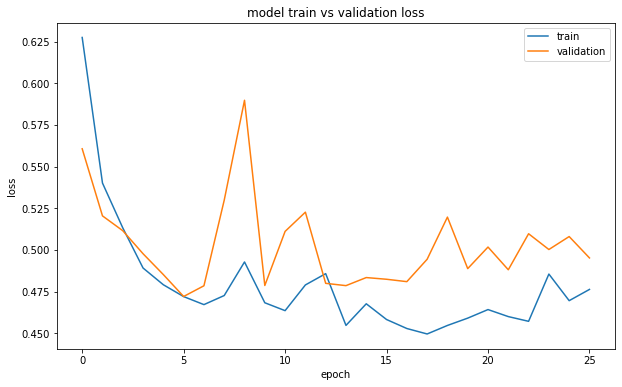

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
model_structure = model.to_json()

with open("/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_500neuron.json", "w") as json_file:
    json_file.write(model_structure)
 
model.save_weights("/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_500neuron_final.h5")

# Load Model and Weights

In [ ]:
from keras.models import model_from_json

# load lstm model structure
with open("/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput.json", "r") as json_file:
    json_string = json_file.read()

model = model_from_json(json_string)

In [ ]:
# load model weights
model.load_weights('/content/drive/MyDrive/Springboard/Capstone Three/LSTM/attention_model_longinput_final.h5')

In [ ]:
from sklearn.preprocessing import LabelEncoder

# provide classes to the label encoder
encoder = LabelEncoder()
encoder.classes_ = np.array(['Negative', 'Neutural', 'Positive'])

In [ ]:
from keras.preprocessing import sequence

X_test = w2v_embedding(X_test)
X_test = sequence.pad_sequences(X_test, maxlen=74, padding='post', truncating='post', dtype='float32')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

y_pred = model.predict_classes(X_test)
y_pred = encoder.inverse_transform(y_pred)

print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))
print('\nBalanced Accuracy Score: {}\n'.format(balanced_accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))